In [1]:
suppressMessages(library(data.table))
suppressMessages(library(tidyverse))
suppressMessages(library(stringr))
suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr))
suppressMessages(library(ggsci))
suppressMessages(library(ggalluvial))
options(warn=-1) # use options(warn=0) To turn warnings back on
options(dplyr.summarise.inform = FALSE)
options(scipen=2)

In [2]:
setwd("/Users/inamojun/TMDU-LR_isoform_atlas/Figures")

In [3]:
#load data
load("../data/data_SupFig01.RData")

In [4]:
data_raw
data_raw %>%
    dplyr::filter(Metrics == "number_of_reads") %>%
    .$dataset %>% as.integer() %>%
    summary()


Metrics,dataset,cell
<chr>,<chr>,<chr>
number_of_reads,6834399,NaiveCD4
number_of_bases,6630686840.0,NaiveCD4
median_read_length,653.0,NaiveCD4
mean_read_length,970.2,NaiveCD4
read_length_stdev,878.2,NaiveCD4
n50,1339.0,NaiveCD4
mean_qual,13.3,NaiveCD4
median_qual,14.0,NaiveCD4
longest_read_(with_Q):1,148175 (5.1),NaiveCD4


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 1996622  3148068  5721968  6277490  7877355 22866118 

In [5]:
# QC

## fastq

### https://bi.biopapyrus.jp/rnaseq/qc/fastq-quality-score.html
#### If the quality score is 10, the probability of a sequencing error is 0.1, so the confidence level of the read base is 90.0%.
#### If the quality score is 20, the probability of a sequencing error is 0.01, so the confidence level of the read base is 99.0%.
#### If the quality score is 30, the probability of a sequencing error is 0.001, so the confidence level of the bases read is 99.9%.


options(repr.plot.width=6, repr.plot.height=6)

g1 = data_raw %>%
  dplyr::filter(Metrics == "number_of_reads") %>%
  dplyr::mutate(cell = stringr::str_split(cell,pattern="_",simplify=TRUE) %>% .[,1]) %>%
  dplyr::group_by(cell) %>%
  dplyr::mutate(dataset = sum(as.integer(dataset))) %>%
  as.data.frame() %>%
  unique() %>%
  dplyr::arrange(dataset) %>%
  # .$dataset %>% summary()
  dplyr::mutate(group = dplyr::case_when(
                  cell == "NaiveCD4" ~ "CD4T",
                  cell == "Th1" ~ "CD4T",
                  cell == "Th2" ~ "CD4T",
                  cell == "Th17" ~ "CD4T",
                  cell == "Tfh" ~ "CD4T",
                  cell == "Fra1" ~ "CD4T",
                  cell == "Fra2-aTreg" ~ "CD4T",
                  cell == "Fra3" ~ "CD4T",
                  cell == "LAG3Treg" ~ "CD4T",
                  cell == "MemoryCD4" ~ "CD4T",
                  cell == "Thx" ~ "CD4T",
                  cell == "NaiveCD8" ~ "CD8T",
                  cell == "CD8effector" ~ "CD8T",
                  cell == "CD8centralmem" ~ "CD8T",
                  cell == "CD8effectormem" ~ "CD8T",
                  cell == "NaiveB" ~ "B",
                  cell == "unswmemoryB" ~ "B",
                  cell == "swmemoryB" ~ "B",
                  cell == "DNB" ~ "B",
                  cell == "plasmablast" ~ "B",
                  cell == "plasmacytoidDC" ~ "DC",
                  cell == "myeloidDC" ~ "DC",
                  cell == "NK" ~ "NK",
                  cell == "monocyteCD16" ~ "Mono",
                  cell == "monocyteCD16minus" ~ "Mono",
                  cell == "nonclassicalMonocyte" ~ "Mono",
                  cell == "intermediateMonocyte" ~ "Mono",
                  cell == "PBMC" ~ "PBMC",
                  cell == "Neutrophil" ~ "Neu"
                ), 
                cell = dplyr::case_when(
                cell == "NaiveCD4" ~ "NaiveCD4",
                cell == "Th1" ~ "Th1",
                cell == "Th2" ~ "Th2",
                cell == "Th17" ~ "Th17",
                cell == "Tfh" ~ "Tfh",
                cell == "Fra1" ~ "Fr.I nTreg",
                cell == "Fra2-aTreg" ~ "Fr.II aTreg",
                cell == "Fra3" ~ "Fr.III non-Treg",
                cell == "LAG3Treg" ~ "LAG3 Treg",
                cell == "MemoryCD4" ~ "Memory CD4",
                cell == "Thx" ~ "X3lowR6negT",
                cell == "NaiveCD8" ~ "NaiveCD8",
                cell == "CD8effector" ~ "Eff CD8",
                cell == "CD8centralmem" ~ "CM CD8",
                cell == "CD8effectormem" ~ "EM CD8",
                cell == "NaiveB" ~ "NaiveB",
                cell == "unswmemoryB" ~ "USMB",
                cell == "swmemoryB" ~ "SMB",
                cell == "DNB" ~ "DNB",
                cell == "plasmablast" ~ "plasmablast",
                cell == "plasmacytoidDC" ~ "pDC",
                cell == "myeloidDC" ~ "mDC",
                cell == "NK" ~ "NK",
                cell == "monocyteCD16minus" ~ "CL Mono",
                cell == "nonclassicalMonocyte" ~ "NC Mono",
                cell == "intermediateMonocyte" ~ "Int Mono",
                cell == "monocyteCD16" ~ "CD16p Mono",
                cell == "PBMC" ~ "PBMC",
                cell == "Neutrophil" ~ "Neu"),
                cell = factor(cell, levels = c(
                    "NaiveCD4","Th1","Th2","Th17","Tfh","Fr.I nTreg","Fr.II aTreg","Fr.III non-Treg","LAG3 Treg","Memory CD4","X3lowR6negT",
                    "NaiveCD8","Eff CD8","CM CD8","EM CD8",
                    "NaiveB","USMB","SMB","DNB","plasmablast",
                    "pDC","mDC",
                    "NK",
                    "CL Mono","NC Mono","Int Mono","CD16p Mono",
                    "PBMC",
                    "Neu"))) %>%
  ggplot(., aes(x = cell, y = dataset, fill = group)) + 
  geom_bar(stat = "identity") +
  ylab("number of reads") +
  coord_flip() +
  theme_classic() +
  theme(strip.text.x=element_text(size=9, color="black", face="bold"),
        strip.text.y=element_text(size=9, color="black", face="bold"),
        legend.position = "bottom",
        plot.title = element_text(size=8),
        axis.title.x = element_text(size=10),
        axis.title.y = element_text(size =10),
        axis.text.y = element_text(size = 10),
        axis.text.x = element_text(size = 10),
        legend.text =  element_text(size = 10), 
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 8, hjust = 0))



In [6]:
data_map
data_map %>%
    dplyr::filter(Metrics == "number_of_reads") %>%
    .$dataset %>% as.integer() %>%
    summary()

Metrics,dataset,cell
<chr>,<chr>,<chr>
number_of_reads,5141279,NaiveCD4
number_of_bases,5221634341.0,NaiveCD4
number_of_bases_aligned,4662669903.0,NaiveCD4
fraction_bases_aligned,0.9,NaiveCD4
median_read_length,703.0,NaiveCD4
mean_read_length,1015.6,NaiveCD4
read_length_stdev,896.9,NaiveCD4
n50,1417.0,NaiveCD4
average_identity,96.1,NaiveCD4


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 1503882  2340022  4566622  4890985  6223502 18232607 

In [7]:
g2 = data_map %>%
  dplyr::filter(Metrics == "number_of_reads") %>%
  dplyr::mutate(cell = stringr::str_split(cell,pattern="_",simplify=TRUE) %>% .[,1]) %>%
  dplyr::group_by(cell) %>%
  dplyr::mutate(dataset = sum(as.integer(dataset))) %>%
  as.data.frame() %>%
  unique() %>%
  dplyr::mutate(group = dplyr::case_when(
                  cell == "NaiveCD4" ~ "CD4T",
                  cell == "Th1" ~ "CD4T",
                  cell == "Th2" ~ "CD4T",
                  cell == "Th17" ~ "CD4T",
                  cell == "Tfh" ~ "CD4T",
                  cell == "Fra1" ~ "CD4T",
                  cell == "Fra2-aTreg" ~ "CD4T",
                  cell == "Fra3" ~ "CD4T",
                  cell == "LAG3Treg" ~ "CD4T",
                  cell == "MemoryCD4" ~ "CD4T",
                  cell == "Thx" ~ "CD4T",
                  cell == "NaiveCD8" ~ "CD8T",
                  cell == "CD8effector" ~ "CD8T",
                  cell == "CD8centralmem" ~ "CD8T",
                  cell == "CD8effectormem" ~ "CD8T",
                  cell == "NaiveB" ~ "B",
                  cell == "unswmemoryB" ~ "B",
                  cell == "swmemoryB" ~ "B",
                  cell == "DNB" ~ "B",
                  cell == "plasmablast" ~ "B",
                  cell == "plasmacytoidDC" ~ "DC",
                  cell == "myeloidDC" ~ "DC",
                  cell == "NK" ~ "NK",
                  cell == "monocyteCD16" ~ "Mono",
                  cell == "monocyteCD16minus" ~ "Mono",
                  cell == "nonclassicalMonocyte" ~ "Mono",
                  cell == "intermediateMonocyte" ~ "Mono",
                  cell == "PBMC" ~ "PBMC",
                  cell == "Neutrophil" ~ "Neu"
                ), 
                cell = dplyr::case_when(
                cell == "NaiveCD4" ~ "NaiveCD4",
                cell == "Th1" ~ "Th1",
                cell == "Th2" ~ "Th2",
                cell == "Th17" ~ "Th17",
                cell == "Tfh" ~ "Tfh",
                cell == "Fra1" ~ "Fr.I nTreg",
                cell == "Fra2-aTreg" ~ "Fr.II aTreg",
                cell == "Fra3" ~ "Fr.III non-Treg",
                cell == "LAG3Treg" ~ "LAG3 Treg",
                cell == "MemoryCD4" ~ "Memory CD4",
                cell == "Thx" ~ "X3lowR6negT",
                cell == "NaiveCD8" ~ "NaiveCD8",
                cell == "CD8effector" ~ "Eff CD8",
                cell == "CD8centralmem" ~ "CM CD8",
                cell == "CD8effectormem" ~ "EM CD8",
                cell == "NaiveB" ~ "NaiveB",
                cell == "unswmemoryB" ~ "USMB",
                cell == "swmemoryB" ~ "SMB",
                cell == "DNB" ~ "DNB",
                cell == "plasmablast" ~ "plasmablast",
                cell == "plasmacytoidDC" ~ "pDC",
                cell == "myeloidDC" ~ "mDC",
                cell == "NK" ~ "NK",
                cell == "monocyteCD16minus" ~ "CL Mono",
                cell == "nonclassicalMonocyte" ~ "NC Mono",
                cell == "intermediateMonocyte" ~ "Int Mono",
                cell == "monocyteCD16" ~ "CD16p Mono",
                cell == "PBMC" ~ "PBMC",
                cell == "Neutrophil" ~ "Neu"),
                cell = factor(cell, levels = c(
                    "NaiveCD4","Th1","Th2","Th17","Tfh","Fr.I nTreg","Fr.II aTreg","Fr.III non-Treg","LAG3 Treg","Memory CD4","X3lowR6negT",
                    "NaiveCD8","Eff CD8","CM CD8","EM CD8",
                    "NaiveB","USMB","SMB","DNB","plasmablast",
                    "pDC","mDC",
                    "NK",
                    "CL Mono","NC Mono","Int Mono","CD16p Mono",
                    "PBMC",
                    "Neu"))) %>%
  ggplot(., aes(x = cell, y = dataset, fill = group)) + 
  geom_bar(stat = "identity") +
  ylab("number of reads") +
  coord_flip() +
  theme_classic() +
  theme(strip.text.x=element_text(size=9, color="black", face="bold"),
        strip.text.y=element_text(size=9, color="black", face="bold"),
        legend.position = "bottom",
        plot.title = element_text(size=8),
        axis.title.x = element_text(size=10),
        axis.title.y = element_text(size =10),
        axis.text.y = element_text(size = 10),
        axis.text.x = element_text(size = 10),
        legend.text =  element_text(size = 10), 
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 8, hjust = 0))

pdf 
  2

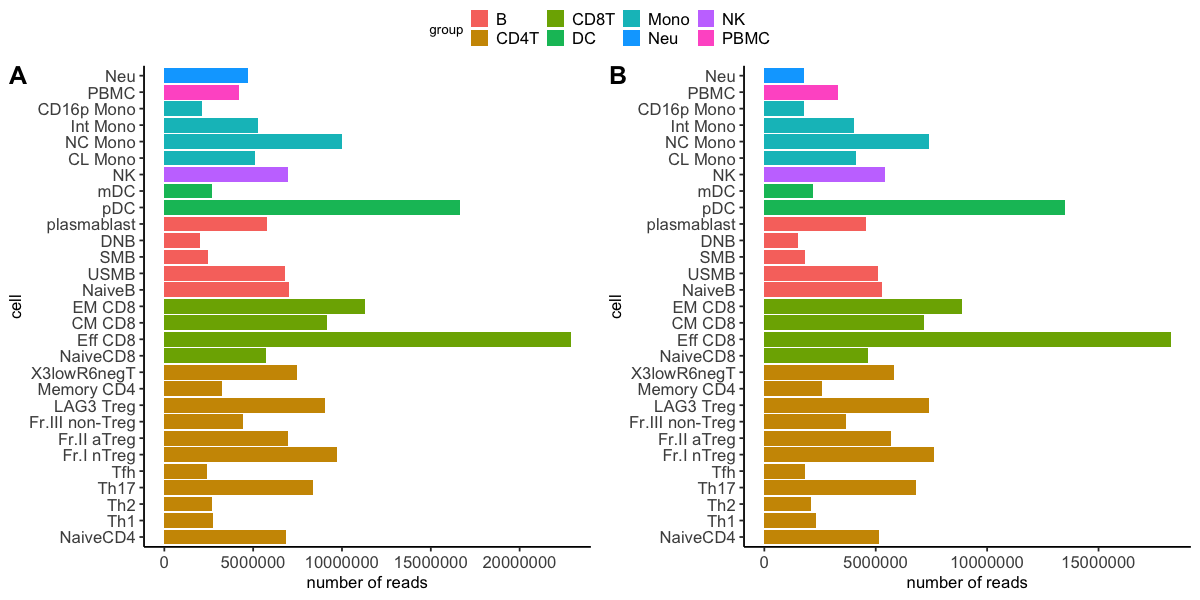

In [8]:
options(repr.plot.width=10, repr.plot.height=5)
ggarrange(g1,g2, 
          nrow = 1, 
          labels = c("A","B"),
          font.label = list(size = 15, color = "black"),
          common.legend = TRUE
          ) 


pdf("./FigS1a.pdf", width=10, height=5)
ggarrange(g1,g2, 
          nrow = 1, 
          labels = c("A","B"),
          font.label = list(size = 15, color = "black"),
          common.legend = TRUE
          ) 
dev.off()

In [9]:
#load data
load("../data/data_SupFig03.RData")

pdf 
  2

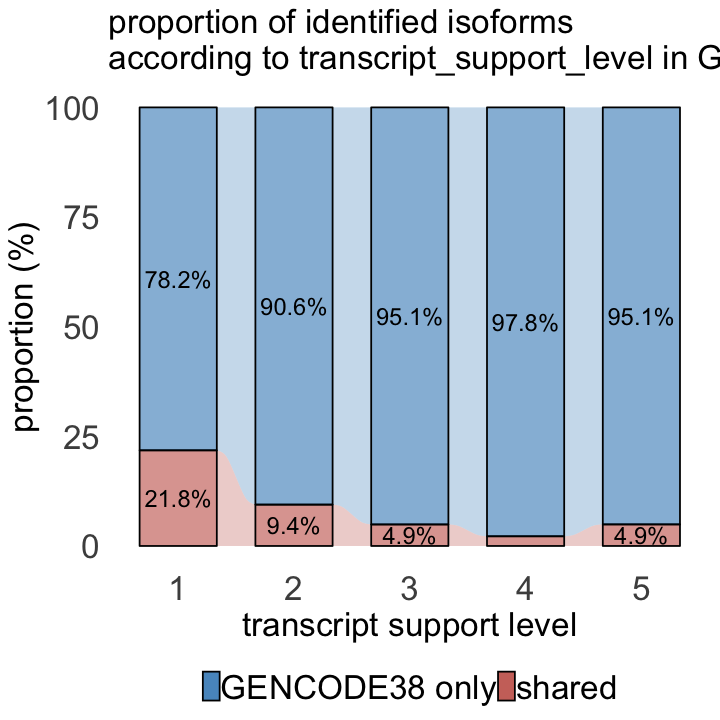

In [10]:
options(repr.plot.width=6, repr.plot.height=6)
g = ggplot(
  support_level %>%
    dplyr::group_by(transcript_support_level,annotation) %>%
    dplyr::summarise(count = n()) %>%
    dplyr::group_by(transcript_support_level) %>%
    dplyr::mutate(proportion = count/sum(count)*100,
                  label = ifelse(proportion > 4,  paste0(round(count/sum(count)*100,digit=1),"%"), "")) %>%
    dplyr::filter(transcript_support_level != "NA"),
  aes(x = transcript_support_level, stratum = annotation, alluvium = annotation,
      y = proportion,
      fill = annotation, label = label)) +
    geom_flow(width = 2/3) +
    geom_stratum(alpha = .5, width = 2/3) +
    geom_text(stat = "stratum", size = 5) +
    scale_fill_manual(values = c(pal_nejm("default", alpha = .5)(8)[2:1],pal_npg("nrc", alpha = 0.3)(10))) +
    ggtitle("proportion of identified isoforms\naccording to transcript_support_level in GENCODE38") +
    xlab("transcript support level") +
    ylab("proportion (%)") +
    theme_minimal() +
    theme(strip.text.x=element_text(size=20, color="black", face="bold"),
          strip.text.y=element_text(size=20, color="black", face="bold"),
          panel.grid=element_blank(),
          legend.position = "bottom",
          plot.title = element_text(size=20),
          axis.title.x = element_text(size=20),
          axis.title.y = element_text(size =20),
          axis.text.y = element_text(size = 20),
          axis.text.x = element_text(size = 20),
          legend.text =  element_text(size = 20), 
          legend.key.size = grid::unit(0.8, "lines"),
          legend.title = element_text(size = 0, hjust = 0))
g
pdf("./FigS1d.pdf", width=6, height=6)
g
dev.off()

In [11]:
#load data
load("../data/data_SupFig04.RData")

In [12]:
res <- resid(mod <- lm(log(isoform_count) ~ log2(total_count+1), data = data))
res.qt <- quantile(res, probs = c(0.05,0.95))
out_below <- which(res < res.qt[1])
out_above <- which(res > res.qt[2])

data[c(out_below,out_above),] %>% nrow()

[1] 1498

pdf 
  2

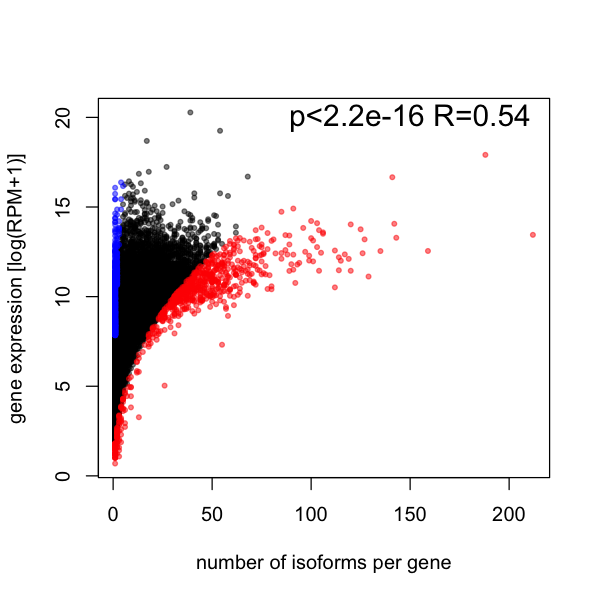

In [13]:
options(repr.plot.width=5, repr.plot.height=5)
test = cor.test(data[,"isoform_count"],data[,"total_count"])
plot(data, type = "n", xlab = "number of isoforms per gene", ylab = "gene expression [log(RPM+1)]",main="")
points(data[-c(out_below,out_above),"isoform_count"], data[-c(out_below,out_above),"total_count"], las = 1, col = alpha("black", 0.5), pch = 20, bg = "black", cex = 0.8);
points(data[out_below,"isoform_count"], data[out_below,"total_count"], las = 1, col = alpha("blue", 0.5), pch = 20, bg = "blue", cex = 0.8);
points(data[out_above,"isoform_count"], data[out_above,"total_count"], las = 1, col = alpha("red", 0.5), pch = 20, bg = "red", cex = 0.8);
text(x=150, y=20, cex = 1.5, col="black", paste0(ifelse(test$p.value == 0, paste0("p<2.2e-16"," R=",format(test$estimate, digit=2)),paste0("p=",format(test$p.value, digit=2),", R=",format(test$estimate, digit=2)))))

pdf("./FigS1e.pdf", width=5, height=5)
test = cor.test(data[,"isoform_count"],data[,"total_count"])
plot(data, type = "n", xlab = "number of isoforms per gene", ylab = "gene expression [log(RPM+1)]",main="")
points(data[-c(out_below,out_above),"isoform_count"], data[-c(out_below,out_above),"total_count"], las = 1, col = alpha("black", 0.5), pch = 20, bg = "black", cex = 0.8);
points(data[out_below,"isoform_count"], data[out_below,"total_count"], las = 1, col = alpha("blue", 0.5), pch = 20, bg = "blue", cex = 0.8);
points(data[out_above,"isoform_count"], data[out_above,"total_count"], las = 1, col = alpha("red", 0.5), pch = 20, bg = "red", cex = 0.8);
text(x=150, y=20, cex = 1.5, col="black", paste0(ifelse(test$p.value == 0, paste0("p<2.2e-16"," R=",format(test$estimate, digit=2)),paste0("p=",format(test$p.value, digit=2),", R=",format(test$estimate, digit=2)))))
dev.off()